# Controlled Abstention Networks (CAN) for regression tasks
* authors: Elizabeth A. Barnes, Randal J. Barnes
* published in Barnes, Elizabeth A. and Randal J. Barnes: Controlled abstention neural networks for identifying skillful predictions for regression problems, submitted to JAMES, 04/2021.
* code updated: April 22, 2021

In [1]:
import os
import time
import sys
import pprint
import imp
import glob

from sklearn import preprocessing
import tensorflow as tf

import numpy as np

import data1d
import metrics
import abstentionloss
import network
import plots

import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['figure.dpi']= 150

np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
tf.print(f"sys.version = {sys.version}", output_stream=sys.stdout)
tf.print(f"tf.version.VERSION = {tf.version.VERSION}", output_stream=sys.stdout)

sys.version = 3.7.9 (default, Aug 31 2020, 07:22:35) 
[Clang 10.0.0 ]
tf.version.VERSION = 2.4.1


# Initialize Experiment

In [2]:
checkpointDir = 'checkpoints/'

EXP_LIST =  {
    'data1d_constant':
            {'exp_name': 'data1d_constant',
            'loss': 'AbstentionLogLoss', 
            'updater': 'Constant',         # set updater to Contant to run with fixed alpha
            'nupd': np.nan, 
            'numClasses': 2, 
            'n_samples': [4000, 1000],     #(number of noisy points, number of not noisy points)             
            'noise': [.5, .05], 
            'slope': [1., .7],
            'yint': [-2., .6],
            'x_sigma': [.25, .5],                  
            'undersample': False,
            'spinup': 0,
            'hiddens': [5, 5],
            'lr_init': .0001,
            'batch_size': 32,
            'np_seed': 99,
            'act_fun': 'relu',
            'kappa_setpoint': .1,
            'fixed_alpha': .1,             # fixed alpha (not using PID controller)
            'n_spinup_epochs': 225,
            'n_coarse_epochs': 0,
            'n_epochs': 1000,    
            'patience': 200,
            'boxcox': False,   
            'ridge_param': 0.,
           },
}
            
EXPINFO = EXP_LIST['data1d_constant']            
EXP_NAME = EXPINFO['exp_name']
pprint.pprint(EXPINFO, width=60)

{'act_fun': 'relu',
 'batch_size': 32,
 'boxcox': False,
 'exp_name': 'data1d_constant',
 'fixed_alpha': 0.1,
 'hiddens': [5, 5],
 'kappa_setpoint': 0.1,
 'loss': 'AbstentionLogLoss',
 'lr_init': 0.0001,
 'n_coarse_epochs': 0,
 'n_epochs': 1000,
 'n_samples': [4000, 1000],
 'n_spinup_epochs': 225,
 'noise': [0.5, 0.05],
 'np_seed': 99,
 'numClasses': 2,
 'nupd': nan,
 'patience': 200,
 'ridge_param': 0.0,
 'slope': [1.0, 0.7],
 'spinup': 0,
 'undersample': False,
 'updater': 'Constant',
 'x_sigma': [0.25, 0.5],
 'yint': [-2.0, 0.6]}


In [3]:
NP_SEED = EXPINFO['np_seed']
np.random.seed(NP_SEED)
tf.random.set_seed(NP_SEED)

## Internal functions

In [4]:
def get_long_name(exp_name, loss_str, setpoint, network_seed, np_seed):
    # set experiment name
    LONG_NAME = (
        exp_name
        + '_' + loss_str            
        + '_setpoint' + str(setpoint)
        + '_networkSeed' + str(network_seed)
        + '_npSeed' + str(np_seed)
    )

    return LONG_NAME

In [5]:
def make_model(loss_str = 'RegressLogLoss', updater_str='Colorado', kappa=1.0e5, tau=1.0e5, spinup_epochs=0, coarse_epochs=0, setpoint=.5, nupd=10, network_seed=0):
    # Define and train the model
    
    tf.keras.backend.clear_session()
    model = network.defineNN(hiddens=HIDDENS, 
                             input_shape=X_train_std.shape[1], 
                             output_shape=NUM_CLASSES, 
                             ridge_penalty=RIDGE, 
                             act_fun=ACT_FUN, 
                             network_seed=network_seed)

    if(loss_str=='AbstentionLogLoss'):
        if(updater_str=='Constant'):
            updater = getattr(abstentionloss, updater_str)(setpoint=setpoint, 
                                                           alpha_init=FIXED_ALPHA, 
                                                           )
            loss_function = getattr(abstentionloss, loss_str)(kappa=kappa,
                                                              tau_fine=kappa,
                                                              updater=updater,
                                                              spinup_epochs=spinup_epochs,
                                                              coarse_epochs=coarse_epochs,
                                                             )                    
        else:
            updater = getattr(abstentionloss, updater_str)(setpoint=setpoint, 
                                                           alpha_init=0.1, 
                                                           length=nupd)
            loss_function = getattr(abstentionloss, loss_str)(
                                                              kappa=kappa,
                                                              tau_fine=tau,
                                                              updater=updater,
                                                              spinup_epochs=spinup_epochs,
                                                              coarse_epochs=coarse_epochs,
                                                             )        
        model.compile(
            optimizer=tf.keras.optimizers.SGD(lr=LR_INIT, momentum=0.9, nesterov=True),
            loss = loss_function,
            metrics=[
                alpha_value,
                metrics.AbstentionFraction(tau=tau),
                metrics.MAE(),                
                metrics.MAECovered(tau=tau),
                metrics.LikelihoodCovered(tau=tau),
                metrics.LogLikelihoodCovered(tau=tau),
                metrics.SigmaCovered(tau=tau),                
            ]
        )   
    else:
        loss_function = getattr(abstentionloss, loss_str)()        
        model.compile(
            optimizer=tf.keras.optimizers.SGD(lr=LR_INIT, momentum=0.9, nesterov=True),
            loss = loss_function,
            metrics=[
                metrics.MAE(),       
                metrics.Likelihood(),
                metrics.LogLikelihood(),                
                metrics.Sigma(),                                
            ]
        )
        
#         model.summary()

        
    return model, loss_function

In [6]:
def get_tau_vector(model,X):
    y_pred = model.predict(X)

    tau_dict = {}
    for perc in np.around(np.arange(.1, 1.1, .1), 3):
        tau_dict[perc] =  np.percentile(y_pred[:, -1], 100-perc*100.)
    
    return tau_dict

def alpha_value(y_true,y_pred):
    return loss_function.updater.alpha

def scheduler(epoch, lr):
    if epoch < LR_EPOCH_BOUND:
        return lr
    else:
        return LR_INIT/2.  # lr*tf.math.exp(-0.1)

class EarlyStoppingCAN(tf.keras.callbacks.Callback):
    """Stop training when the loss is at its min, i.e. the loss stops decreasing.

  Arguments:
      patience: Number of epochs to wait after min has been hit. After this
      number of no improvement, training stops.
  """

    def __init__(self, patience=0, updater_str='Colorado'):
        super(EarlyStoppingCAN, self).__init__()
        self.patience = patience
        self.updater_str = updater_str
        # best_weights to store the weights at which the minimum loss occurs.
        self.best_weights = None

    def on_train_begin(self, logs=None):
        # The number of epoch it has waited when loss is no longer minimum.
        self.wait = 0
        # The epoch the training stops at.
        self.stopped_epoch = 0
        # Initialize the best to be the worse possible.
        self.best = np.Inf
        self.best_epoch = 0
        # initialize best_weights to non-trained model
        self.best_weights = self.model.get_weights()
        

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get("val_loss")
        if np.less(current, self.best):
            if(self.updater_str=='Constant'):
                abstention_error = 0.
            else:
                abstention_error = np.abs(logs.get("val_abstention_fraction") - setpoint)
            if np.less(abstention_error, .1):
                if (epoch >= EXPINFO['n_spinup_epochs']):                
                    self.best = current
                    self.wait = 0
                    # Record the best weights if current results is better (greater).
                    self.best_weights = self.model.get_weights()
                    self.best_epoch = epoch
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                print("Restoring model weights from the end of the best epoch.")
                self.model.set_weights(self.best_weights)

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            print("Early stopping, setting to best_epoch = " + str(self.best_epoch + 1))
        else:
            self.best_epoch = np.nan       

## Make the data


noise fraction = 80.0%
training samples shapes = (3000,)
validation samples shapes = (1000,)
testing samples shapes = (1000,)
not actually standardizing the data



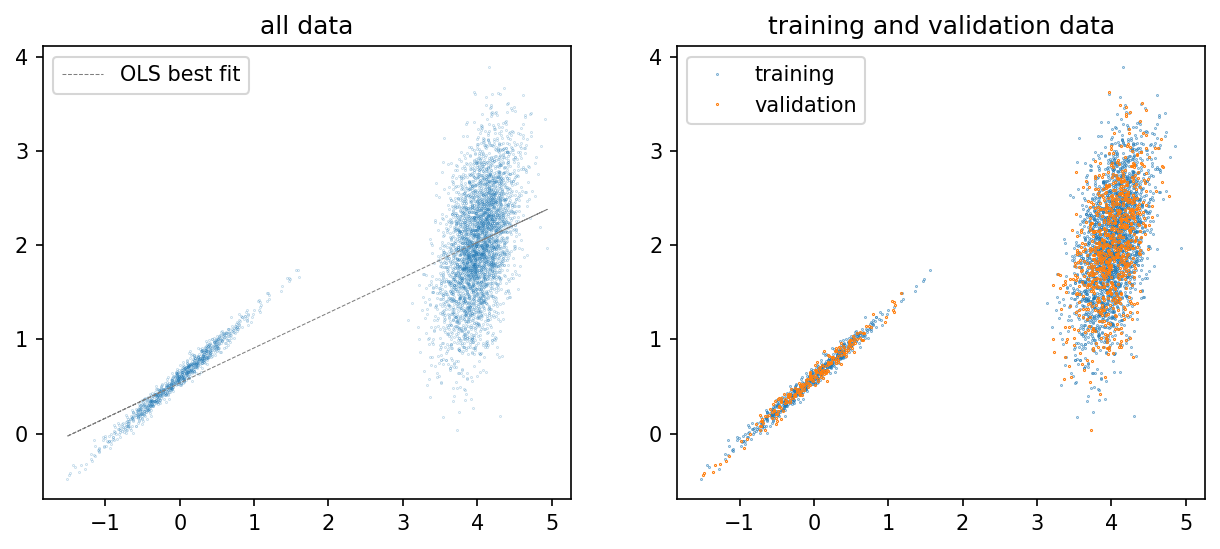

In [7]:
X_train_std, onehot_train, X_val_std, onehot_val, X_test_std, onehot_test, xmean, xstd, tr_train, tr_val, tr_test = data1d.get_data(EXPINFO,to_plot=True)

# Train the model

data1d_constant_RegressLogLoss_setpoint-1.0_networkSeed0_npSeed99
        elapsed time during fit = 22.08 seconds



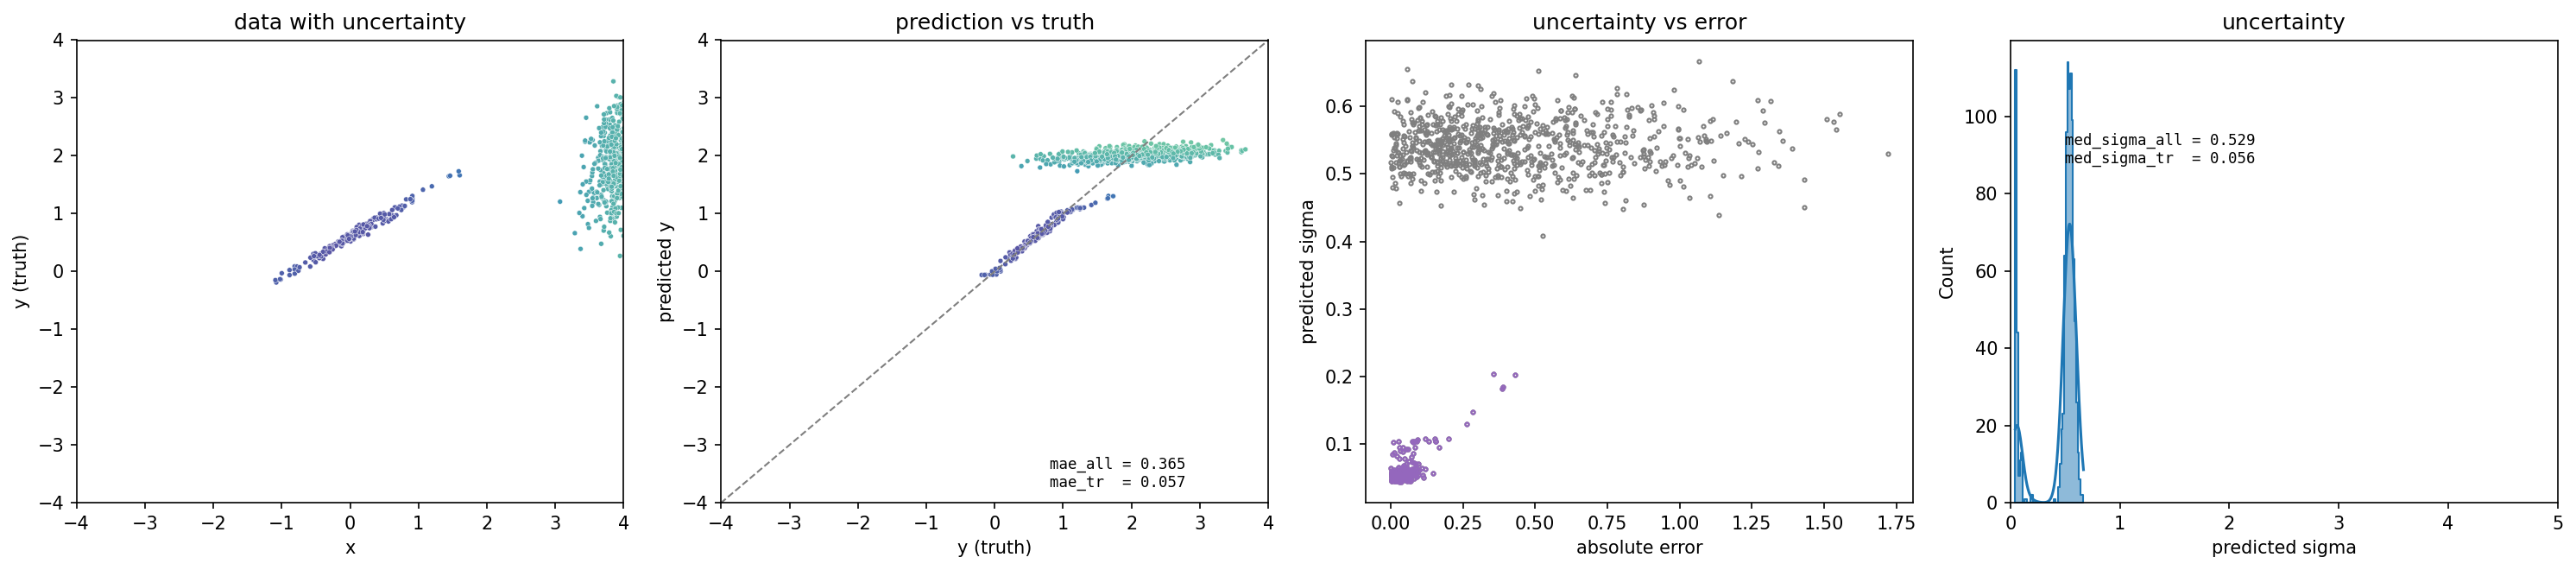

data1d_constant_RegressLogLoss_setpoint0.0_networkSeed0_npSeed99
Restoring model weights from the end of the best epoch.
Epoch 00900: early stopping
        elapsed time during fit = 83.57 seconds



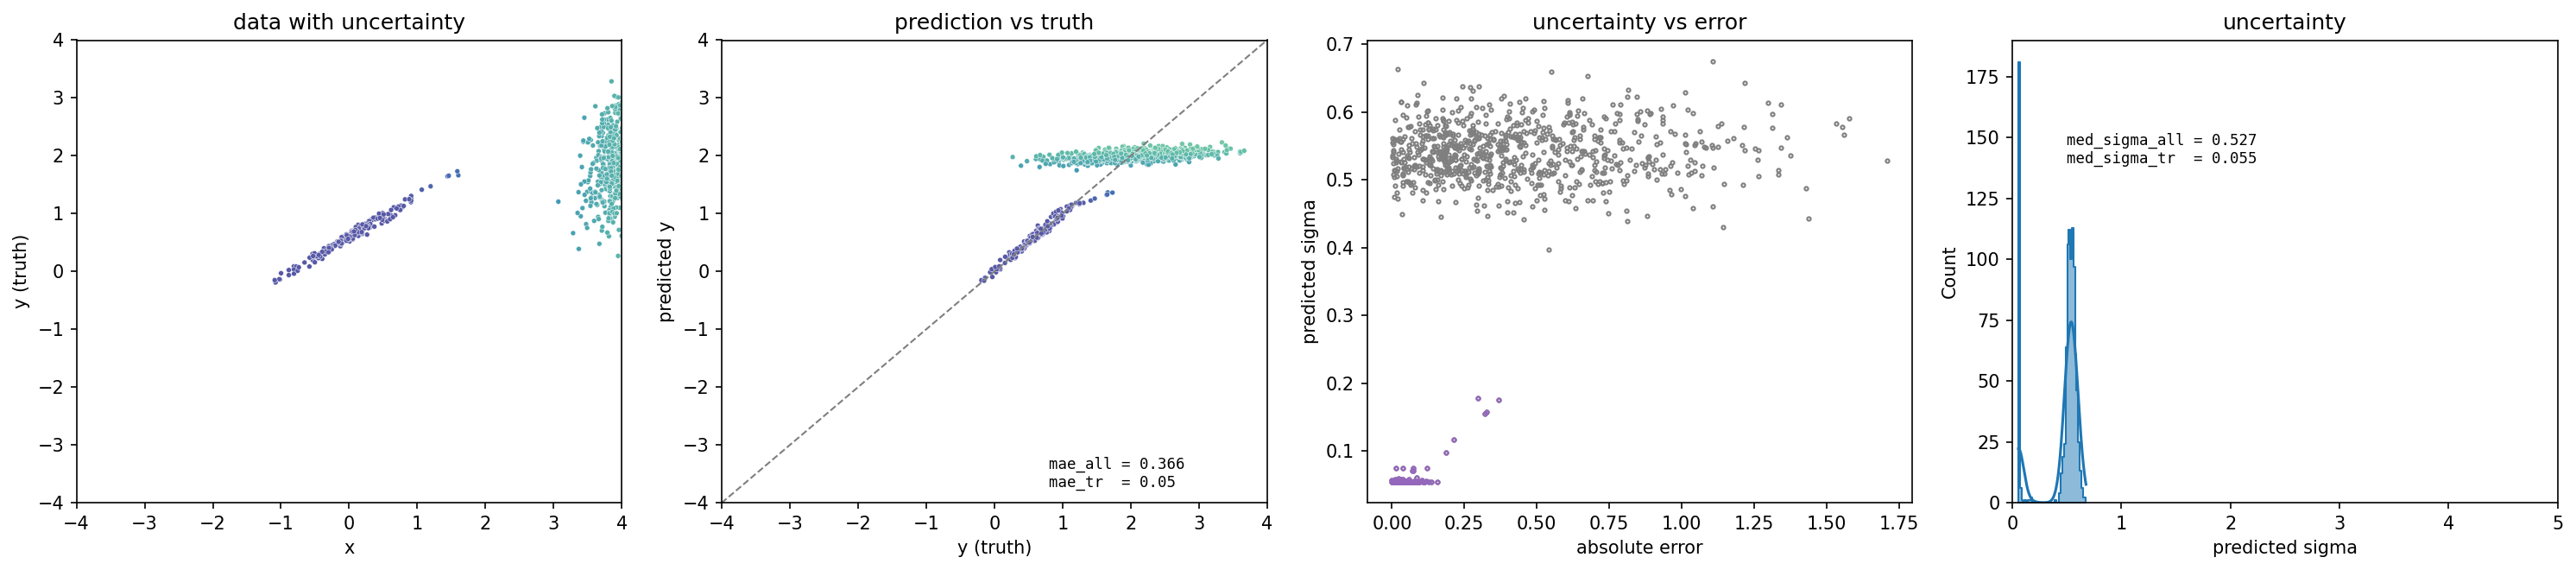

data1d_constant_AbstentionLogLoss_setpoint0.2_networkSeed0_npSeed99
    kappa = 0.5769451916217805, tau = 0.5633968234062194
Restoring model weights from the end of the best epoch.
Early stopping, setting to best_epoch = 599
        elapsed time during fit = 104.93 seconds



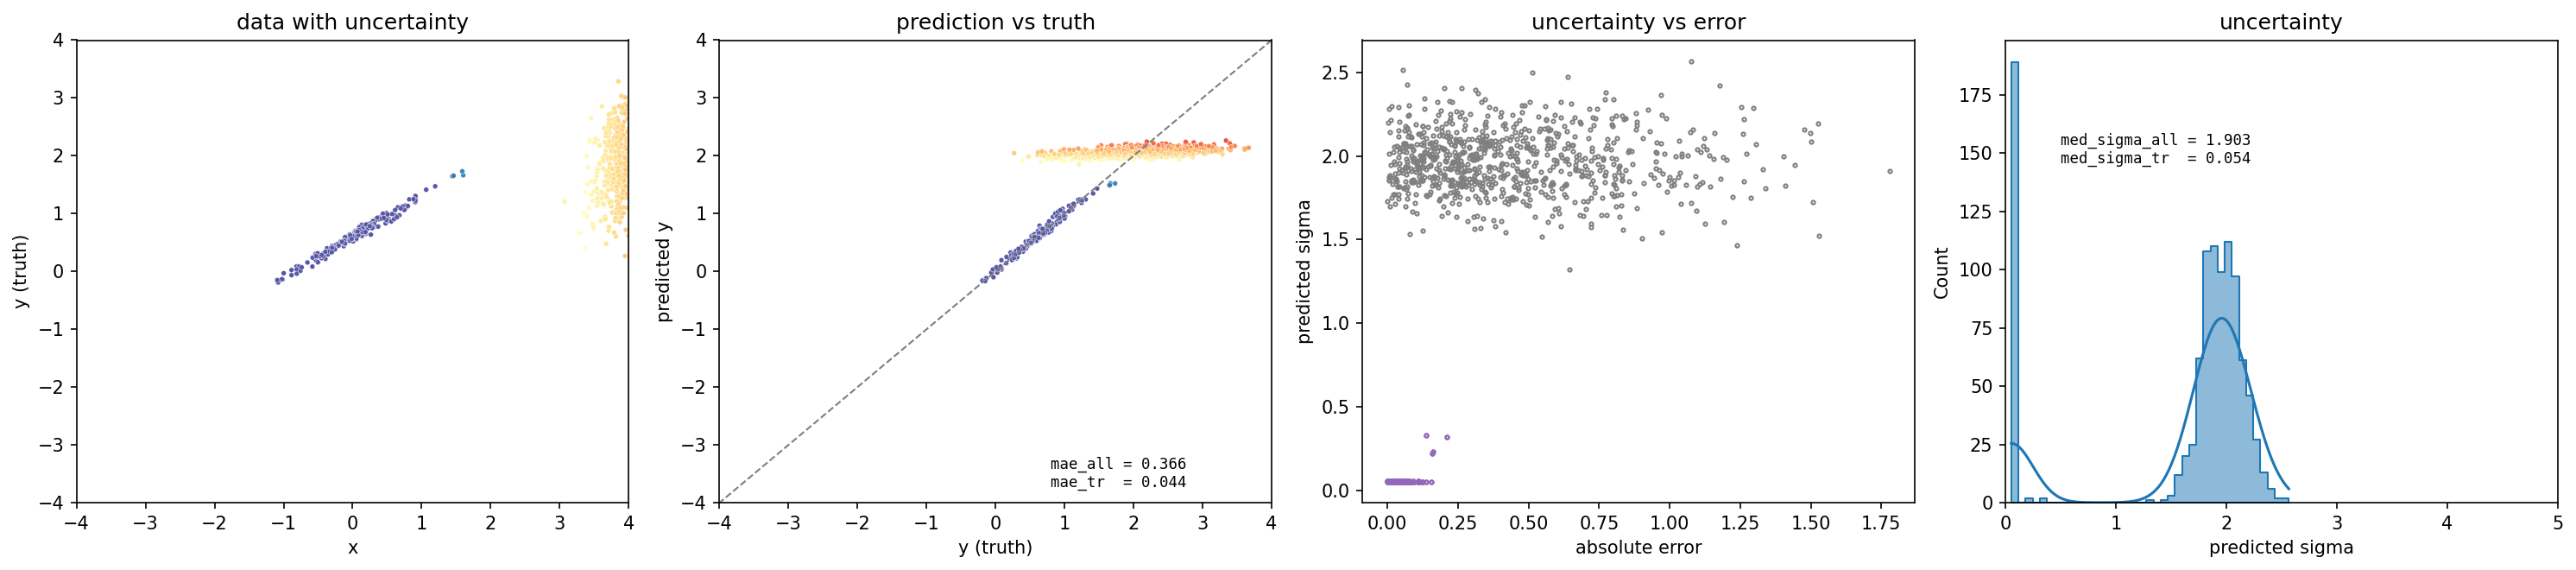

In [8]:
#---------------------
LOSS = EXPINFO['loss']
UPDATER = EXPINFO['updater']
ACT_FUN = EXPINFO['act_fun']
NUPD = EXPINFO['nupd']
HIDDENS = EXPINFO['hiddens']
BATCH_SIZE = EXPINFO['batch_size']
LR_INIT = EXPINFO['lr_init']
NUM_CLASSES = EXPINFO['numClasses']
RIDGE = EXPINFO['ridge_param']
KAPPA_SEPOINT = EXPINFO['kappa_setpoint']
N_SPINUP_EPOCHS = EXPINFO['n_spinup_epochs']
N_COARSE_EPOCHS = EXPINFO['n_coarse_epochs']
PATIENCE = EXPINFO['patience']
FIXED_ALPHA = EXPINFO['fixed_alpha']
#---------------------
# Set parameters
LR_EPOCH_BOUND = 10000         # don't use the learning rate scheduler, but keep as an option
NETWORK_SEED = 0
SETPOINT_LIST = [-1., 0., .2,] # -1.     = fit model for spinup period only with RegressionLogLoss
                               #  0.     = fit model with RegressionLogLoss
                               # (0,1)  = fit with AbstentionLogLoss for setpoint coverage, 
                               #          choose any value (0,1) if running with UPDATER = 'Constant'


for isetpoint, setpoint in enumerate(SETPOINT_LIST):

    # set loss function to use ----
    N_EPOCHS = EXPINFO['n_epochs']
    if(setpoint==0.):
        if(LOSS == 'AbstentionLogLoss'):
            RUN_LOSS = 'RegressLogLoss'
        else:
            RUN_LOSS = LOSS
    elif(setpoint==-1.):
        if(LOSS == 'AbstentionLogLoss'):
            RUN_LOSS = 'RegressLogLoss'            
            N_EPOCHS = EXPINFO['n_spinup_epochs']
        else:
            continue
    else:            
        if(LOSS != 'AbstentionLogLoss' ):
            continue
        else:
            RUN_LOSS = LOSS

    #-------------------
    LONG_NAME = get_long_name(EXP_NAME, RUN_LOSS, setpoint, NETWORK_SEED, NP_SEED)
    model_name = 'saved_models/model_' +  LONG_NAME
    print(LONG_NAME)

    #-------------------------------
    # load the baseline spin-up model
    if(setpoint>0):
        spinup_file = 'saved_models/model_' +  get_long_name(exp_name=EXP_NAME, 
                                                             loss_str='RegressLogLoss', 
                                                             setpoint=-1., 
                                                             network_seed=NETWORK_SEED, 
                                                             np_seed=NP_SEED)
        model_spinup, __ = make_model(loss_str = RUN_LOSS,
                                      network_seed=NETWORK_SEED,
                                     )
        model_spinup.load_weights(spinup_file + '.h5')
        tau_dict = get_tau_vector(model_spinup,X_val_std)
        KAPPA = tau_dict[KAPPA_SEPOINT]
        TAU = tau_dict[setpoint]
        print('    kappa = ' + str(KAPPA) + ', tau = ' + str(TAU))            
    else:
        TAU = np.nan
        KAPPA = np.nan

    #-------------------------------
    # set random seed again
    np.random.seed(NP_SEED)
    # get the model
    tf.keras.backend.clear_session()

    # callbacks
    lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose=0)
    cp_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath = checkpointDir + 'model_' + LONG_NAME + '_epoch{epoch:03d}.h5', 
        verbose=0, 
        save_weights_only=True,
    )

    # define the model and loss function
    if(RUN_LOSS=='AbstentionLogLoss'):   # run with AbstentionLogLoss
        es_can_callback = EarlyStoppingCAN(patience=PATIENCE, 
                                           updater_str=UPDATER,
                                          )
        model, loss_function = make_model(loss_str = RUN_LOSS, 
                                          updater_str=UPDATER, 
                                          kappa = KAPPA,                                              
                                          tau = TAU,
                                          spinup_epochs=N_SPINUP_EPOCHS, 
                                          coarse_epochs=N_COARSE_EPOCHS,
                                          setpoint=setpoint, 
                                          nupd=NUPD,
                                          network_seed=NETWORK_SEED,
                                         )
        callbacks = [abstentionloss.AlphaUpdaterCallback(), 
                     lr_callback, 
                     cp_callback,
                     es_can_callback,
                    ]
    else:  # run with RegressLogLoss
        es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                       mode='min',
                                                       patience=PATIENCE, 
                                                       restore_best_weights=True, 
                                                       verbose=1)                    
        model, loss_function = make_model(loss_str = RUN_LOSS,
                                          network_seed=NETWORK_SEED,
                                         )
        callbacks = [lr_callback, 
                     cp_callback, 
                     es_callback,
                    ]            

    #-------------------------------
    # Train the model
    start_time = time.time()
    history = model.fit(
                        X_train_std,
                        onehot_train,
                        validation_data=(X_val_std, onehot_val),
                        batch_size=BATCH_SIZE,
                        epochs=N_EPOCHS,
                        shuffle=True,
                        verbose=0,
                        callbacks=callbacks
                    )        

    stop_time = time.time()
    tf.print(f"        elapsed time during fit = {stop_time - start_time:.2f} seconds\n")

    model.save_weights(model_name + '.h5')
    for f in glob.glob(checkpointDir + 'model_' + LONG_NAME + "_epoch*.h5"):
        os.remove(f)        

    #-------------------------------
    # Display the results
    if(RUN_LOSS=='AbstentionLogLoss'):
        best_epoch = es_can_callback.best_epoch
    elif(setpoint==-1):
        best_epoch = N_EPOCHS 
    else:
        best_epoch = np.argmin(history.history['val_loss'])
    exp_info=(RUN_LOSS, N_EPOCHS, setpoint, N_SPINUP_EPOCHS, HIDDENS, LR_INIT, LR_EPOCH_BOUND, BATCH_SIZE, NETWORK_SEED, best_epoch)

    #---- plot nice predictions ----
    y_pred = model.predict(X_test_std)
    plots.plot_predictionscatter(X_test_std, y_pred, onehot_test[:,0], tr_test, LONG_NAME, showplot = True)
